In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [3]:
# Memuat dataset
df = pd.read_csv("DampakBencanaFinal.csv", delimiter=";")

In [4]:
df.head()

,No.,Wilayah,Jumlah Kejadian,Meninggal,Terluka,Menderita,Mengungsi,Rusak Berat,Rusak Sedang,Rusak Ringan,Terendam
0,1,Aceh,945,150,1393,738705,580495,1317758,985941,1122634,776703
1,2,Sumatera Utara,469,64,112,288564,1152879,1510,1477,1357687,752181
2,3,Sumatera Barat,570,15,35,1300706,1334,143,186,420,550313
3,4,Riau,229,12,36,1597291,31345,398,769,1273106,244662
4,5,Jambi,226,5,13,541614,135115,473,467,1147,92749


In [5]:
# Buatkan EDA dan berikan deskripsinya :
# 2 line plot
# 2 box plot
# 2 pie chart
# scatter plot
# corelation matrix

In [6]:
# Boxplot Korban Meninggal berdasarkan Wilayah
#sns.boxplot(data=df,
            #x='Wilayah',
            #y='Hilang',
            #palette='Set3')
#plt.title("Distribusi Korban Hilang berdasarkan Wilayah")
#plt.xlabel("Wilayah")
#plt.ylabel("Hilang (Orang)")
#plt.xticks(rotation=90, ha='right')
#plt.show()

In [7]:
columns_to_convert = ['Jumlah Kejadian', 'Meninggal', 'Terluka', 'Menderita', 'Mengungsi', 'Rusak Berat', 'Rusak Sedang', 'Rusak Ringan', 'Terendam']
for cols in columns_to_convert:
    df[cols] = df[cols].astype(str).str.replace(',', '.', regex=False)
    df[cols] = pd.to_numeric(df[cols], errors='coerce')


In [8]:
features = ['Jumlah Kejadian',
            'Meninggal',
            'Terluka',
            'Menderita',
            'Mengungsi',
            'Rusak Berat',
            'Rusak Sedang',
            'Rusak Ringan',
            'Terendam']

In [9]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# Modeling

In [10]:
# Menentukan jumlah cluster menggunakan metode elbow
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

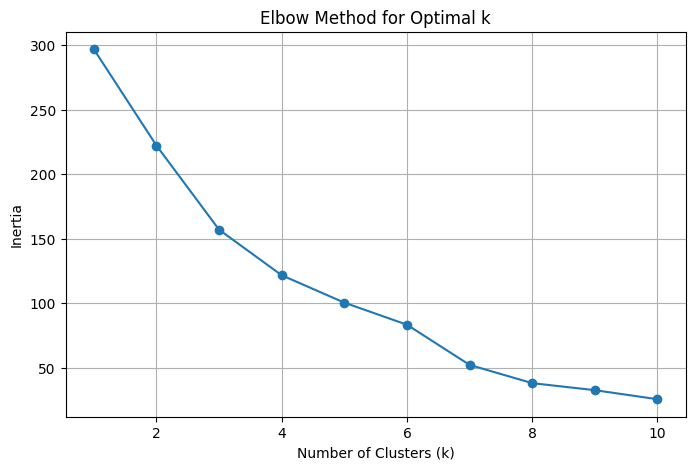

In [11]:
# Plot Elbow Method
plt.figure(figsize=(8,5))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid()
plt.show()

In [12]:
# Menggunakan jumlah cluster optimal
optimal_k = 4 # Berdasarkan elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# Evaluasi

In [13]:
silhouette_avg = silhouette_score(scaled_features, df['Cluster'])
print(f"Silhouette Score untuk k={optimal_k}: {silhouette_avg:.4f}")

Silhouette Score untuk k=4: 0.3375


In [14]:
print("\nRingkasan Profil Kluster (Rata-rata Nilai Fitur):")
kluster_summary = df.groupby('Cluster')[features].mean()
kluster_summary['Jumlah Wilayah'] = df.groupby('Cluster').size()
print(kluster_summary.round(2))

print("\nDetail Wilayah per Kluster:")
for i in range(optimal_k):
    print(f"\nKluster {i}:")
    print(df[df['Cluster'] == i]['Wilayah'].tolist())


Ringkasan Profil Kluster (Rata-rata Nilai Fitur):
         Jumlah Kejadian  Meninggal  Terluka   Menderita  Mengungsi  \
Cluster                                                               
0                3414.50     105.00    97.00   239504.00   72151.00   
1                 282.43       7.76    16.29  1231264.33  106239.81   
2                 945.00     150.00  1393.00   738705.00  580495.00   
3                 355.44      21.89   257.78   515285.89  876918.78   

         Rusak Berat  Rusak Sedang  Rusak Ringan   Terendam  Jumlah Wilayah  
Cluster                                                                      
0           19821.00      16427.50     138435.50  370445.00               2  
1             205.76        227.52      96969.48  306857.57              21  
2         1317758.00     985941.00    1122634.00  776703.00               1  
3             418.89        404.78     234460.89  843343.00               9  

Detail Wilayah per Kluster:

Kluster 0:
['Jawa Barat'

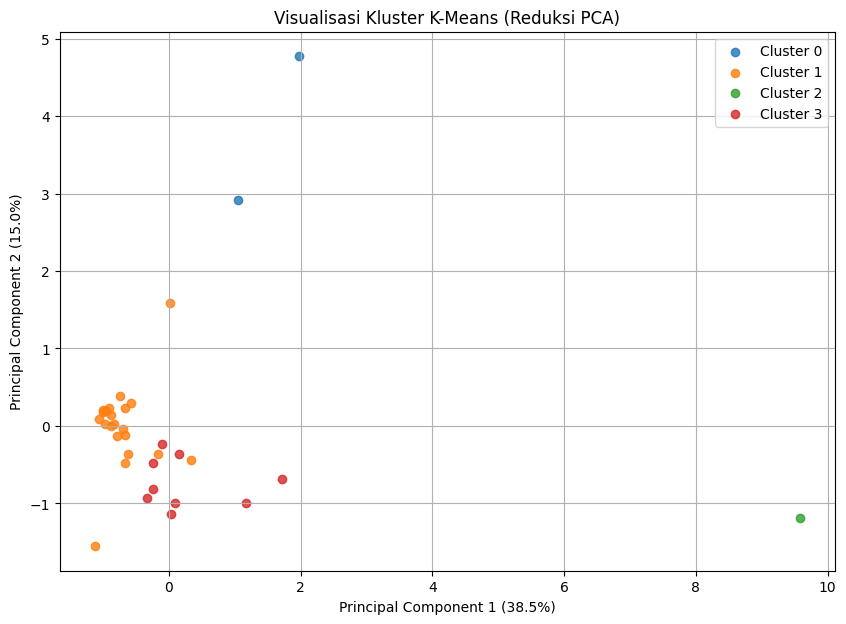

In [15]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
pca_df['Cluster'] = df['Cluster']

plt.figure(figsize=(10, 7))
for i in range(optimal_k):
    subset = pca_df[pca_df['Cluster'] == i]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {i}', alpha=0.8)

# Menandai Wilayah di Kluster Outlier (misalnya Kluster 1: CIANJUR)
# outlier_index = df[df['Wilayah'] == 'CIANJUR'].index[0]
# plt.scatter(pca_df.loc[outlier_index, 'PC1'], pca_df.loc[outlier_index, 'PC2'],
            # marker='X', s=200, color='red', label='CIANJUR (Ekstrem)')

plt.title('Visualisasi Kluster K-Means (Reduksi PCA)')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.legend()
plt.grid()
plt.show()